# BP, BP-F and MLR-F model comparison
The notebook aims to compare 3 different approaches. Those are the Multiple Linear Regression (MLR-F), the Neural Network with Back-Propagation and the Neural Network with Back-Propagation (BP-F). For all three approaches we will use the same dataset, which is the one generated by the [generate_preprocessed_dataset.py](./generate_preprocessed_dataset.py) script.

## Requirements
To run the current notebook you will need to confirm first that you have installed the requirements listed in [requirements.txt](./requirements.txt). Alternatively, you can run:

In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Common Variables
In this section we are going to import all the common libraries and define all static variables.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from NeuralNet import NeuralNet, relu, relu_derivative


DATA_TEST_PATH = "data_test.csv"
DATA_TRAIN_PATH = "data_train.csv"
HIDDEN_LAYERS = [32, 12]
LEARNING_RATE = 0.01
MOMENTUM = 0.99
NUM_OF_EPOCHS = 1000
OUTPUT_LAYER = [1]
PLOT_FIGURE_SIZE = (8, 6)
RESULTS_TEST_PATH = "result_test.csv"
RESULTS_TRAIN_PATH = "result_train.csv"
VALIDATION_RATIO = 0.15

X_train = np.genfromtxt(DATA_TRAIN_PATH, delimiter=",")
y_train = np.genfromtxt(RESULTS_TRAIN_PATH, delimiter=",")
X_test = np.genfromtxt(DATA_TEST_PATH, delimiter=",")
y_test = np.genfromtxt(RESULTS_TEST_PATH, delimiter=",")

## Approach 1: Multiple Linear Regression (MLR-F)
For the implementation of this approach we will use `scikit-learn` library. The source code is the following.

In [18]:
# Initialize and train the model
mlr_f = LinearRegression()
mlr_f.fit(X_train, y_train)

# Make predictions
mlr_y_pred = mlr_f.predict(X_test)

# Get the MLR F mean square, mean absolute and mean absolute percentage error
mlr_mean_square_error = mean_squared_error(y_test, mlr_y_pred)
mlr_mean_absolute_error = mean_absolute_error(y_test, mlr_y_pred)
mlr_mean_absolute_percentage_error = mean_absolute_percentage_error(y_test, mlr_y_pred)
print(f"MLR-F Mean Square Error:: {mlr_mean_square_error:.6f}")
print(f"MLR-F Mean Absolute Error:: {mlr_mean_absolute_error:.6f}")
print(f"MLR-F Mean Absolute Percentage Error:: {mlr_mean_absolute_percentage_error:.6f}")

MLR-F Mean Square Error:: 0.000494
MLR-F Mean Absolute Error:: 0.018544
MLR-F Mean Absolute Percentage Error:: 0.042925


## Approach 2: NeuralNet.py with BackPropagation
For the implementation of this approach we will use the neural network already implemented in [NeuralNet.py](./NeuralNet.py). The source code is the following:

In [19]:
# Get the total number of features
_, total_features = X_train.shape

# Initialize the neural network
total_layers = [total_features] + HIDDEN_LAYERS + OUTPUT_LAYER
nn_bp = NeuralNet(
    total_layers=len(total_layers),
    units_per_layer=total_layers,
    learning_rate=LEARNING_RATE,
    fact=relu,
    fact_derivative=relu_derivative,
    validation_percentage=VALIDATION_RATIO,
    num_of_epochs=NUM_OF_EPOCHS,
)

# Train the neural network
nn_bp.fit(
    X_train,
    y_train,
)

# Make predictions
nn_bp_pred = nn_bp.predict(X_test)

# Get the neural network BP mean square, mean absolute and mean absolute percentage error
nn_bp_mean_square_error = mean_squared_error(y_test, nn_bp_pred)
nn_bp_mean_absolute_error = mean_absolute_error(y_test, nn_bp_pred)
nn_bp_mean_absolute_percentage_error = mean_absolute_percentage_error(y_test, nn_bp_pred)

print(f"Neural Network with BP Mean Square Error:: {nn_bp_mean_square_error:.6f}")
print(f"Neural Network with BP Mean Absolute Error:: {nn_bp_mean_absolute_error:.6f}")
print(f"Neural Network with BP Mean Absolute Percentage Error:: {nn_bp_mean_absolute_percentage_error:.6f}")

Neural Network with BP Mean Square Error:: 0.005072
Neural Network with BP Mean Absolute Error:: 0.036846
Neural Network with BP Mean Absolute Percentage Error:: 0.083816


## Approach 3: Neural Network with BP-F
For this implementation we will use `pytorch`. The source code is:

In [20]:
class RegressionModel(nn.Module):
    def __init__(
        self, input_size: "int", hidden_layers: "list[int]", output_size: "int"
    ) -> None:
        super(RegressionModel, self).__init__()

        # Initialize the input layer
        _layers = [nn.Linear(input_size, hidden_layers[0]), nn.ReLU()]

        # Initialize the hidden layers
        for i in range(1, len(hidden_layers)):
            _layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            _layers.append(nn.ReLU())

        # Initialize the Output layer
        _layers.append(nn.Linear(hidden_layers[-1], output_size))

        # Combine into a sequential model
        self.model = nn.Sequential(*_layers)

    def forward(self, x):
        return self.model(x)


# Convert X and y to tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().view(-1, 1)

# Get the total number of features
_, total_features = X_train.shape

# Construct the BP-F pytorch neural network model, its loss and its optimizer
bp_f = RegressionModel(
    input_size=total_features, hidden_layers=HIDDEN_LAYERS, output_size=1
)
loss_fn = nn.MSELoss(size_average=None, reduce=None)
optimizer = optim.SGD(bp_f.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)


# Training loop (same as NeuralNet
for epoch in range(NUM_OF_EPOCHS):
    # _forward
    predictions = bp_f(X_train_tensor)
    loss = loss_fn(predictions, y_train_tensor)
    # _backward
    optimizer.zero_grad()
    loss.backward()
    # _update_weights
    optimizer.step()


with torch.no_grad():
    nn_bp_f_pred = bp_f(X_test_tensor)
    test_loss = loss_fn(nn_bp_f_pred, y_test_tensor)
    print(f"Test Loss: {test_loss.item()}")

# Get the neural network BP-F mean square, mean absolute and mean absolute percentage error
nn_bp_f_mean_square_error = mean_squared_error(y_test, nn_bp_f_pred)
nn_bp_f_mean_absolute_error = mean_absolute_error(y_test, nn_bp_f_pred)
nn_bp_f_mean_absolute_percentage_error = mean_absolute_percentage_error(y_test, nn_bp_f_pred)

print(f"Neural Network with BP-F Mean Square Error:: {nn_bp_f_mean_square_error:.6f}")
print(f"Neural Network with BP-F Mean Absolute Error:: {nn_bp_f_mean_absolute_error:.6f}")
print(f"Neural Network with BP-F Mean Absolute Percentage Error:: {nn_bp_f_mean_absolute_percentage_error:.6f}")

Test Loss: 0.00016317474364768714
Neural Network with BP-F Mean Square Error:: 0.000163
Neural Network with BP-F Mean Absolute Error:: 0.010423
Neural Network with BP-F Mean Absolute Percentage Error:: 0.022365


## Visualizations & Plots
This section includes visualization (scatter plots) comparing all three models and more specifically we are plotting the predictions with the real values.

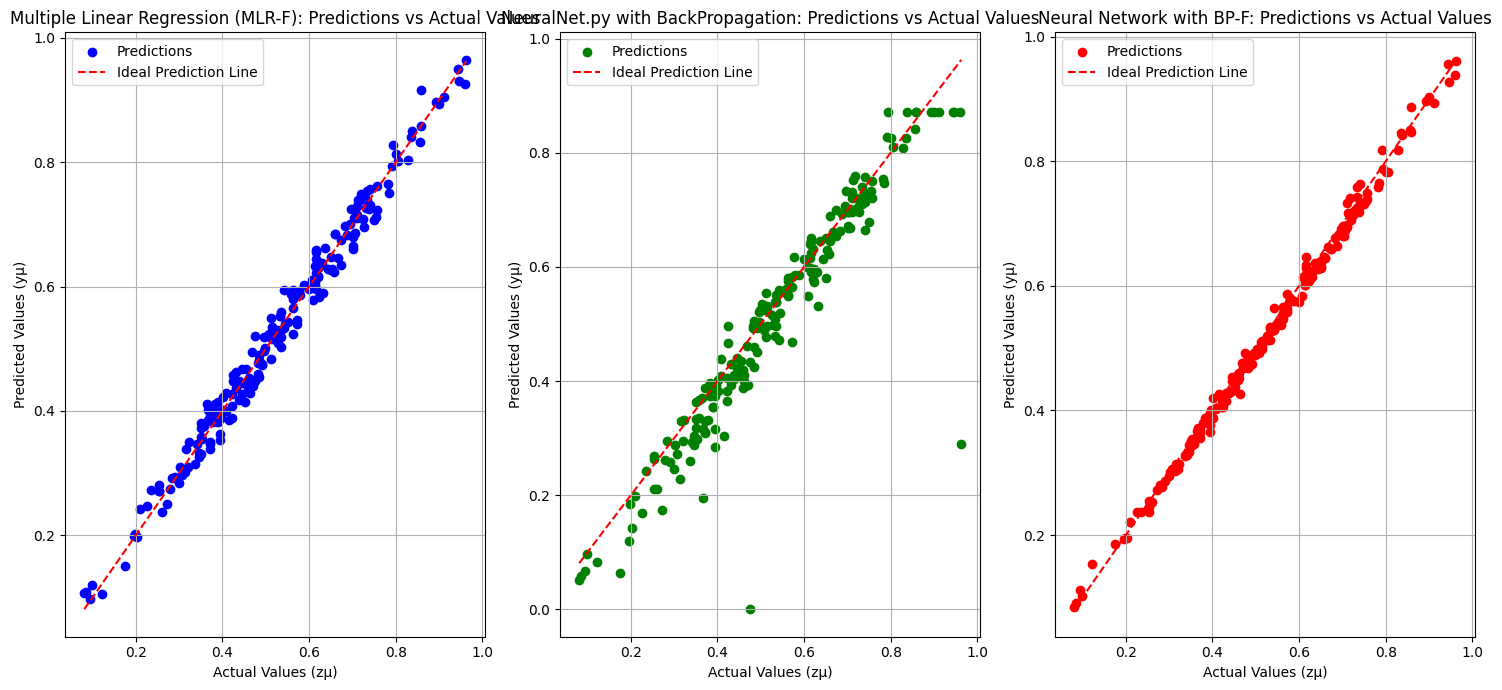

In [21]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

# Scatter plot for Approach 1: Multiple Linear Regression (MLR-F)
axes[0].scatter(y_test, mlr_y_pred, color='blue', label='Predictions')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Prediction Line')
axes[0].set_title('Multiple Linear Regression (MLR-F): Predictions vs Actual Values')
axes[0].set_xlabel('Actual Values (zμ)')
axes[0].set_ylabel('Predicted Values (yμ)')
axes[0].legend()
axes[0].grid(True)

# Scatter plot for Approach 2: NeuralNet.py with BackPropagation
axes[1].scatter(y_test, nn_bp_pred, color='green', label='Predictions')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Prediction Line')
axes[1].set_title('NeuralNet.py with BackPropagation: Predictions vs Actual Values')
axes[1].set_xlabel('Actual Values (zμ)')
axes[1].set_ylabel('Predicted Values (yμ)')
axes[1].legend()
axes[1].grid(True)

# Scatter plot for Approach 3: NeuralNet.py with BackPropagation
axes[2].scatter(y_test, nn_bp_f_pred, color='red', label='Predictions')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Prediction Line')
axes[2].set_title('Neural Network with BP-F: Predictions vs Actual Values')
axes[2].set_xlabel('Actual Values (zμ)')
axes[2].set_ylabel('Predicted Values (yμ)')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()